<a href="https://colab.research.google.com/github/it-dieuanh/LSTMpredictStock/blob/main/Stock_Price_Prediction_by_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Import needed libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Section 2: Read and Preprocess Data


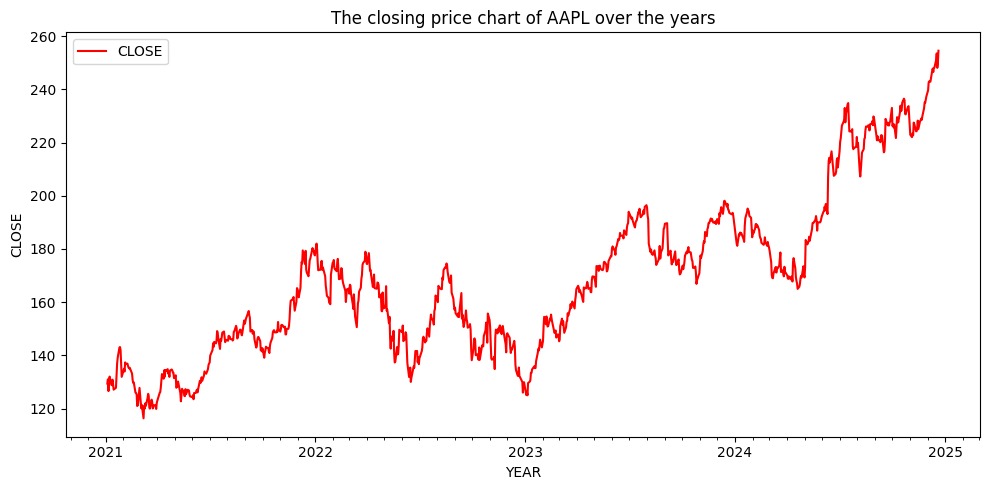

In [58]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

df['DATE'] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')

df = df.sort_values(by='DATE')

df['CLOSE'] = df['CLOSE'].astype(str).str.replace(',', '').astype(float)
df['OPEN'] = df['OPEN'].astype(str).str.replace(',', '').astype(float)
df['HIGH'] = df['HIGH'].astype(str).str.replace(',', '').astype(float)
df['LOW'] = df['LOW'].astype(str).str.replace(',', '').astype(float)

df['YEAR'] = df['DATE'].dt.year

plt.figure(figsize=(10, 5))
plt.plot(df['DATE'], df['CLOSE'], label='CLOSE', color='red')
plt.xlabel('YEAR')
plt.ylabel('CLOSE')
plt.title('The closing price chart of AAPL over the years')
plt.legend(loc='best')

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()


# Section 3: Prepare Data for Model


In [59]:
df1 = pd.DataFrame(df, columns=['DATE', 'CLOSE'])
df1.index = df1.DATE
df1.drop('DATE', axis=1, inplace=True)

data = df1.values
train_data = data[:1500]
test_data = data[1500:]

sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i-50:i, 0])
    y_train.append(sc_train[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Section 4: Build and Train LSTM Model


In [60]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = "save_model.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=200, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.13735, saving model to save_model.keras
19/19 - 6s - 323ms/step - loss: 0.1373
Epoch 2/200

Epoch 2: loss improved from 0.13735 to 0.06947, saving model to save_model.keras
19/19 - 4s - 219ms/step - loss: 0.0695
Epoch 3/200

Epoch 3: loss improved from 0.06947 to 0.06189, saving model to save_model.keras
19/19 - 4s - 185ms/step - loss: 0.0619
Epoch 4/200

Epoch 4: loss improved from 0.06189 to 0.05715, saving model to save_model.keras
19/19 - 3s - 133ms/step - loss: 0.0571
Epoch 5/200

Epoch 5: loss did not improve from 0.05715
19/19 - 2s - 107ms/step - loss: 0.0588
Epoch 6/200

Epoch 6: loss improved from 0.05715 to 0.05497, saving model to save_model.keras
19/19 - 3s - 145ms/step - loss: 0.0550
Epoch 7/200

Epoch 7: loss improved from 0.05497 to 0.05414, saving model to save_model.keras
19/19 - 4s - 195ms/step - loss: 0.0541
Epoch 8/200

Epoch 8: loss did not improve from 0.05414
19/19 - 4s - 196ms/step - loss: 0.0559
Epoch 9/200

Epoch 9: loss i

# Section 5: Load Best Model and Predict on Training Data


In [61]:
final_model = load_model("save_model.keras")
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


# Section 6: Prepare Test Data


In [62]:
test = df1[len(train_data)-50:].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]+1):
    x_test.append(sc_test[i-50:i, 0])
x_test = np.array(x_test)

if x_test.size > 0:
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = data[1500:]
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


# Section 7: Compare Actual vs Predicted Prices


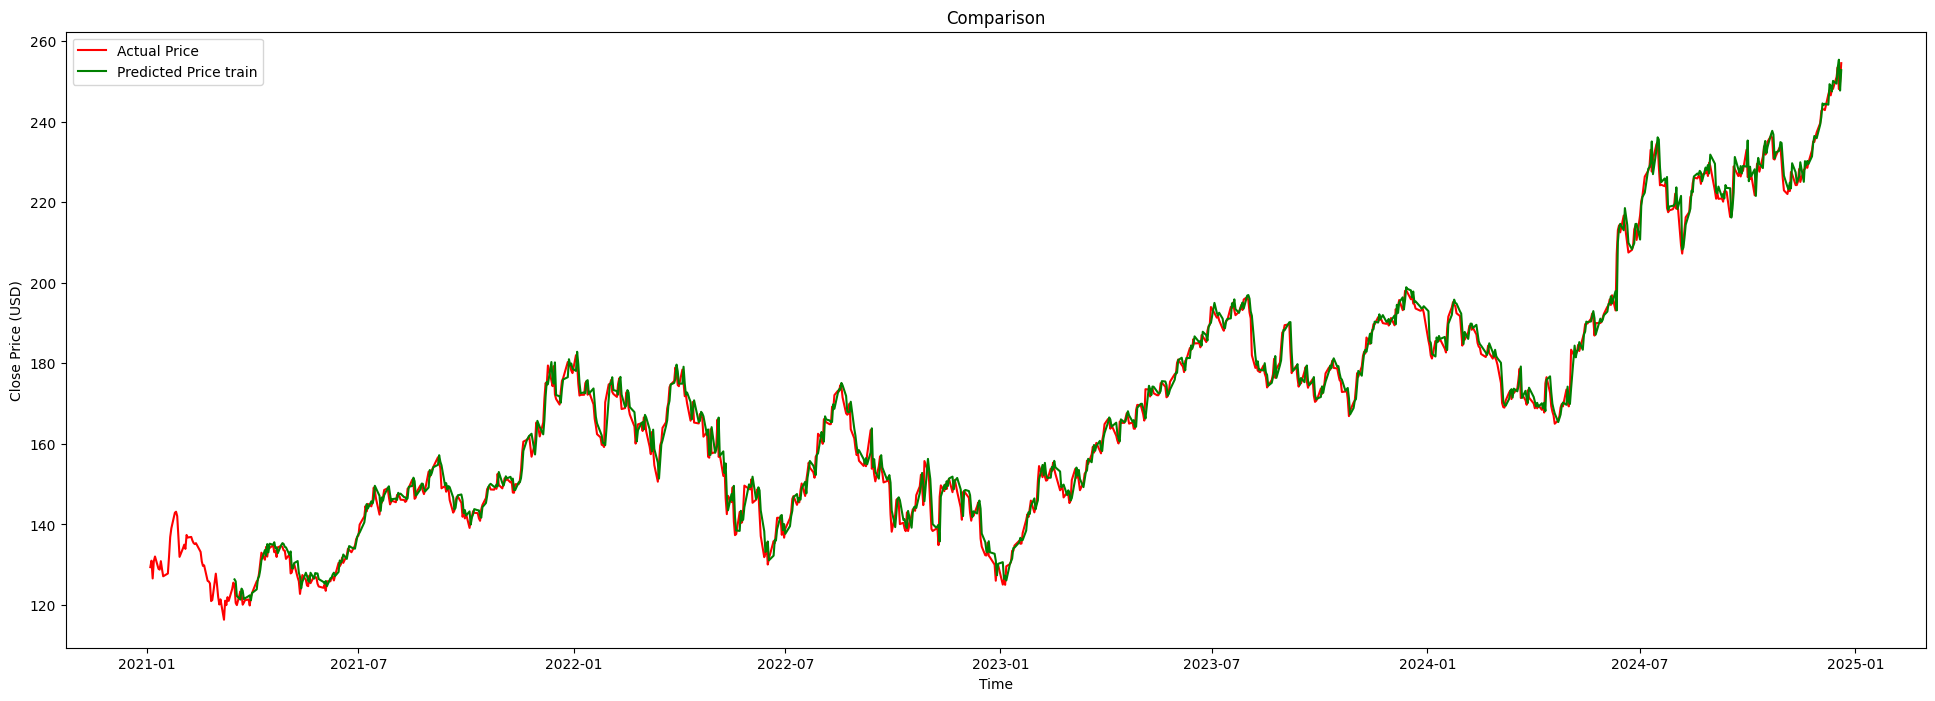

In [63]:
train_data1 = df1[50:1500].copy()
test_data1 = df1[1500:].copy()

plt.figure(figsize=(24, 8))
plt.plot(df1, label='Actual Price', color='red')
train_data1.loc[:, 'Predicted Price'] = y_train_predict
plt.plot(train_data1['Predicted Price'], label='Predicted Price train', color='green')

plt.title('Comparison')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()


# Section 8: Evaluate Model Performance


In [64]:
print('R2 score on train set:', r2_score(y_train, y_train_predict))
print('Mean Absolute Error on train set (USD):', mean_absolute_error(y_train, y_train_predict))
print('Mean Absolute Percentage Error on train set:', mean_absolute_percentage_error(y_train, y_train_predict))

R2 score on train set: -654373.5619508723
Mean Absolute Error on train set (USD): 170.53818287282527
Mean Absolute Percentage Error on train set: 600.2421094618019


# Section 9: Predict Next Closing Price


In [65]:
next_date = df['DATE'].iloc[-1] + pd.Timedelta(days=1)
next_date = pd.to_datetime(next_date)

next_closing_price = np.array([df['CLOSE'].iloc[-1]])
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))

x_next = np.array([sc_train[-50:, 0]])
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

df_next = pd.DataFrame({'DATE': [next_date], 'CLOSE': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


# Section 10: Compare Predicted vs Previous Day Price


In [66]:
actual_closing_price = df['CLOSE'].iloc[-1]
comparison_df = pd.DataFrame({'DATE': [next_date], 'Predicted Price': [y_next_predict[0][0]], 'Previous Day Price': [actual_closing_price]})
print(comparison_df)

        DATE  Predicted Price  Previous Day Price
0 2024-12-21          257.138              254.49
